<a href="https://colab.research.google.com/github/sushirito/Methylmercury/blob/main/TST_Boltzmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This code was inspired by: https://github.com/lbm-principles-practice/code/blob/master/chapter9/shanchen.cpp



Porous medium shape: (400, 400)
Porosity: 0.8236


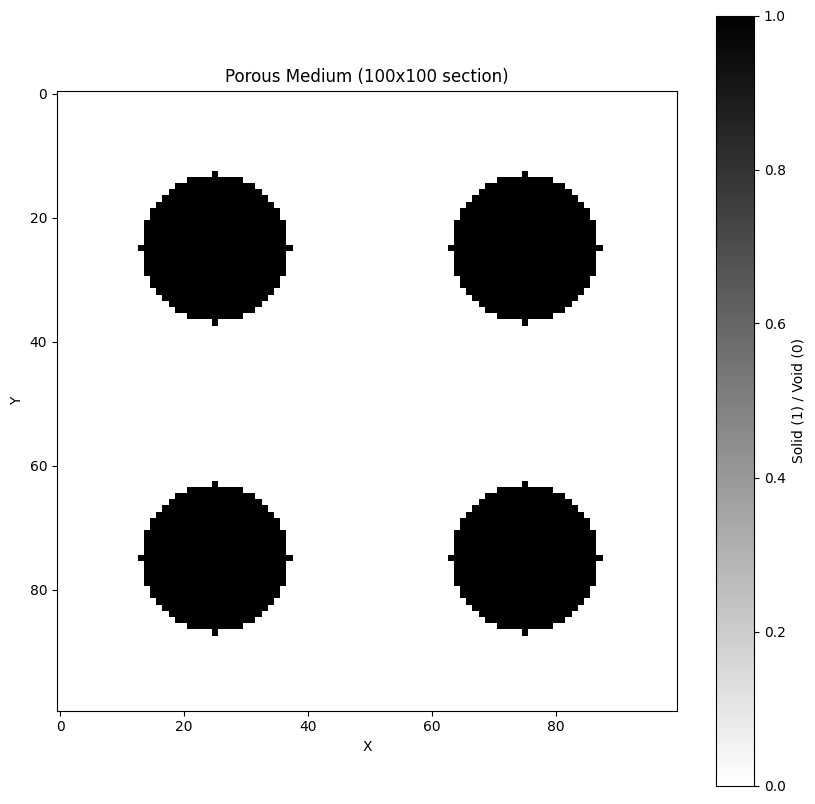

In [3]:
import numpy as np

def create_elementary_pattern(size=50):
    """Create an elementary pattern of a square obstacle."""
    pattern = np.zeros((size, size), dtype=int)
    center = size // 2
    radius = size // 4

    for y in range(size):
        for x in range(size):
            if (x - center)**2 + (y - center)**2 <= radius**2:
                pattern[y, x] = 1

    return pattern

def create_porous_medium(n_patterns=8):
    """Create a porous medium by replicating the elementary pattern."""
    elementary_size = 50
    pattern = create_elementary_pattern(elementary_size)

    # Replicate the pattern
    porous_medium = np.tile(pattern, (n_patterns, n_patterns))

    return porous_medium

# Create the porous medium
nx, ny = 64, 64  # Total size of the domain
solid = create_porous_medium()

print(f"Porous medium shape: {solid.shape}")
print(f"Porosity: {1 - np.mean(solid):.4f}")

# Visualize a small part of the porous medium
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(solid[:100, :100], cmap='binary')
plt.title("Porous Medium (100x100 section)")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="Solid (1) / Void (0)")
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np

# Lattice parameters
nx = 400  # number of nodes along x-axis (adjusted to match porous medium size)
ny = 400  # number of nodes along y-axis (adjusted to match porous medium size)
nsteps = 500  # number of time steps
noutput = 100  # data output interval (data written to "/data")
nfluids = 1  # number of fluid components (choose 1 or 2)
tauA = 1  # relaxation time for fluid A
tauB = 1  # relaxation time for fluid B (will only be used if nfluids = 2)

# Shan-Chen parameters
gA = -0.16  # self-interaction strength of fluid A (as specified in the paper)
gB = 0.  # self-interaction strength of fluid B (will only be used if nfluids = 2)
gAB = 6.  # interaction strength of fluids A and B (will only be used if nfluids = 2)
rho0 = 1.  # reference density for pseudopotential (usually set to 1)
rhol = 2.1  # initial liquid density
rhog = 0.15  # initial gas density
radius = 15.  # initial droplet radius

# Solid-fluid interaction parameters
W = 0.15  # Solid-fluid interaction strength (as specified in the paper for fully wetting solid)

# Gravitational force
g_gravity = 9.81e-5  # Gravitational acceleration (adjusted for lattice units, might need fine-tuning)

# Fixed parameters; DO NOT CHANGE
npop = 9  # number of populations
cx = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])  # x-components of lattice vectors
cy = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])  # y-components of lattice vectors
weight = np.array([4./9., 1./9., 1./9., 1./9., 1./9., 1./36., 1./36., 1./36., 1./36.])

# Weights for fluid-fluid interactions (D2Q9 lattice)
t_G = np.array([0, 2, 2, 2, 2, 1, 1, 1, 1])

# Weights for solid-fluid interactions (D2Q9 lattice)
t_w = np.array([0, 2, 2, 2, 2, 1, 1, 1, 1])

# Arrays
g = np.zeros((nfluids, nfluids))  # interaction strengths
rho = np.zeros((nfluids, nx * ny))  # density
press = np.zeros(nx * ny)  # pressure
ux = np.zeros(nx * ny)  # x-component of fluid velocity
uy = np.zeros(nx * ny)  # y-component of fluid velocity
Fx = np.zeros((nfluids, nx * ny))  # x-component of Shan-Chen force
Fy = np.zeros((nfluids, nx * ny))  # y-component of Shan-Chen force
feq = np.zeros((nfluids, npop))  # equilibrium populations
forcing = np.zeros((nfluids, npop))  # force populations
tau = np.zeros(nfluids)  # relaxation times
f1 = np.zeros((nfluids, nx * ny, npop))  # populations (old)
f2 = np.zeros((nfluids, nx * ny, npop))  # populations (new)

# Solid matrix (porous medium)
def create_elementary_pattern(size=50):
    pattern = np.zeros((size, size), dtype=int)
    center = size // 2
    radius = size // 4
    for y in range(size):
        for x in range(size):
            if (x - center)**2 + (y - center)**2 <= radius**2:
                pattern[y, x] = 1
    return pattern

def create_porous_medium(n_patterns=8):
    elementary_size = 50
    pattern = create_elementary_pattern(elementary_size)
    porous_medium = np.tile(pattern, (n_patterns, n_patterns))
    return porous_medium

solid = create_porous_medium()  # This creates a 400x400 porous medium

def compute_density(pop):
    for s in range(nfluids):
        rho[s] = np.sum(pop[s], axis=1)

def psi(dens):
    return rho0 * (1. - np.exp(-dens / rho0))

def compute_sc_forces():
    for y in range(ny):
        for x in range(nx):
            k = y * nx + x
            for s in range(nfluids):
                Fx[s, k] = 0.
                Fy[s, k] = 0.

                # Fluid-fluid interactions (Shan-Chen force)
                for ss in range(nfluids):
                    fxtemp = 0.
                    fytemp = 0.
                    for i in range(1, npop):
                        x2 = (x + cx[i] + nx) % nx
                        y2 = (y + cy[i] + ny) % ny
                        psinb = psi(rho[ss, y2 * nx + x2])
                        fxtemp += t_G[i] * cx[i] * psinb
                        fytemp += t_G[i] * cy[i] * psinb
                    psiloc = psi(rho[s, k])
                    Fx[s, k] += -g[s, ss] * psiloc * fxtemp
                    Fy[s, k] += -g[s, ss] * psiloc * fytemp

                # Solid-fluid interactions
                fxtemp_solid = 0.
                fytemp_solid = 0.
                for i in range(1, npop):
                    x2 = (x + cx[i] + nx) % nx
                    y2 = (y + cy[i] + ny) % ny
                    s_value = solid[y2, x2]
                    fxtemp_solid += t_w[i] * cx[i] * s_value
                    fytemp_solid += t_w[i] * cy[i] * s_value
                psiloc = psi(rho[s, k])
                Fx[s, k] += -W * psiloc * fxtemp_solid
                Fy[s, k] += -W * psiloc * fytemp_solid

                # Gravity force
                Fy[s, k] += -rho[s, k] * g_gravity

    return Fx, Fy

def compute_total_density(k):
    if nfluids == 1:
        return rho[0, k]
    elif nfluids == 2:
        return rho[0, k] + rho[1, k]

def compute_pressure():
    for y in range(ny):
        for x in range(nx):
            k = y * nx + x
            press[k] = 0.
            for s in range(nfluids):
                press[k] += rho[s, k] / 3.
                for ss in range(nfluids):
                    press[k] += (g[s, ss] * psi(rho[s, k]) * psi(rho[ss, k]) / 6.)

def compute_velocity(pop):
    for y in range(ny):
        for x in range(nx):
            k = y * nx + x
            ux[k] = 0.
            uy[k] = 0.
            for s in range(nfluids):
                ux[k] += (pop[s, k, 1] - pop[s, k, 3] + pop[s, k, 5] - pop[s, k, 6] - pop[s, k, 7] + pop[s, k, 8])
                uy[k] += (pop[s, k, 2] - pop[s, k, 4] + pop[s, k, 5] + pop[s, k, 6] - pop[s, k, 7] - pop[s, k, 8])
                ux[k] += (0.5 * Fx[s, k])
                uy[k] += (0.5 * Fy[s, k])
            dens = compute_total_density(k)
            ux[k] /= dens
            uy[k] /= dens

def equilibrium(s, k):
    dens = rho[s, k]
    vx = ux[k]
    vy = uy[k]
    usq = vx * vx + vy * vy
    feq[s, 0] = weight[0] * dens * (1. - 1.5 * usq)
    feq[s, 1] = weight[1] * dens * (1. + 3. * vx + 4.5 * vx * vx - 1.5 * usq)
    feq[s, 2] = weight[2] * dens * (1. + 3. * vy + 4.5 * vy * vy - 1.5 * usq)
    feq[s, 3] = weight[3] * dens * (1. - 3. * vx + 4.5 * vx * vx - 1.5 * usq)
    feq[s, 4] = weight[4] * dens * (1. - 3. * vy + 4.5 * vy * vy - 1.5 * usq)
    feq[s, 5] = weight[5] * dens * (1. + 3. * (vx + vy) + 4.5 * (vx + vy) * (vx + vy) - 1.5 * usq)
    feq[s, 6] = weight[6] * dens * (1. + 3. * (-vx + vy) + 4.5 * (-vx + vy) * (-vx + vy) - 1.5 * usq)
    feq[s, 7] = weight[7] * dens * (1. + 3. * (-vx - vy) + 4.5 * (vx + vy) * (vx + vy) - 1.5 * usq)
    feq[s, 8] = weight[8] * dens * (1. + 3. * (vx - vy) + 4.5 * (vx - vy) * (vx - vy) - 1.5 * usq)

def initialisation():
    global f1, f2, rho
    rho = np.zeros((nfluids, nx * ny))
    # Set viscosity
    tau[0] = tauA
    if nfluids == 2:
        tau[1] = tauB

    # Set interaction strength
    g[0, 0] = gA
    if nfluids == 2:
        g[1, 1] = gB
        g[0, 1] = g[1, 0] = gAB

    # Initialise 1-component system
    if nfluids == 1:
        for k in range(nx * ny):
            if ((k // nx - ny // 2) ** 2 + (k % nx - nx // 2) ** 2) <= radius ** 2:
                rho[0, k] = rhol  # liquid density
            else:
                rho[0, k] = rhog  # gas density

    # Initialise 2-component system
    if nfluids == 2:
        for y in range(ny):
            for x in range(nx):
                k = y * nx + x
                if y < ny // 2:
                    rho[0, k] = 0.1
                    rho[1, k] = 0.9
                else:
                    rho[0, k] = 0.9
                    rho[1, k] = 0.1

    # Initialise populations
    for s in range(nfluids):
        for k in range(nx * ny):
            ux[k] = uy[k] = 0.
            equilibrium(s, k)
            f1[s, k] = feq[s]
            f2[s, k] = feq[s]

def push():
    global f1, f2
    for s in range(nfluids):
        omega = 1. / tau[s]
        for y in range(ny):
            for x in range(nx):
                k = y * nx + x
                # Compute Guo's forcing terms
                for i in range(npop):
                    forcing[s, i] = weight[i] * (1. - 0.5 * omega) * ((3. * (cx[i] - ux[k]) + 9. * cx[i] * (cx[i] * ux[k] + cy[i] * uy[k])) * Fx[s, k] + (3. * (cy[i] - uy[k]) + 9. * cy[i] * (cx[i] * ux[k] + cy[i] * uy[k])) * Fy[s, k])
                # Compute equilibrium distributions
                equilibrium(s, k)
                # Collide and propagate
                for i in range(npop):
                    x2 = (x + cx[i] + nx) % nx
                    y2 = (y + cy[i] + ny) % ny
                    f2[s, y2 * nx + x2, i] = f1[s, k, i] * (1. - omega) + feq[s, i] * omega + forcing[s, i]
    f1, f2 = f2, f1

def calculate_delta_pressure():
    global press

    rho_gas = 0.
    rho_liq = 0.
    press_gas = 0.
    press_liq = 0.

    # Average gas pressure in a square box with 4 lattice nodes
    for x in range(4):
        for y in range(4):
            k = y * nx + x
            rho_gas += rho[0, k]
            press_gas += press[k]

    # Average liquid pressure in a square box with 4 lattice nodes
    for x in range(nx // 2 - 2, nx // 2 + 2):
        for y in range(ny // 2 - 2, ny // 2 + 2):
            k = y * nx + x
            rho_liq += rho[0, k]
            press_liq += press[k]

    rho_gas /= 16.
    rho_liq /= 16.
    press_gas /= 16.
    press_liq /= 16.

    delta_press = press_liq - press_gas
    rho_av = 0.5 * (rho_gas + rho_liq)
    y = ny // 2
    rad = 0

    for x in range(nx // 2):
        k = y * nx + x
        if rho[0, k] > rho_av:
            drho = rho[0, k] - rho[0, k-1]
            dx = (rho_av - rho[0, k-1]) / drho
            rad = (nx / 2. - x) + (1. - dx)
            break

    gamma = delta_press * rad

    print(f"  Densities: rho_g = {rho_gas:.6f}, rho_l = {rho_liq:.6f}")
    print(f"  Pressure difference: dp = {delta_press:.6f}")
    print(f"  Droplet radius: r = {rad:.6f}")
    print(f"  Surface tension: gamma = {gamma:.6f}")

# Create a directory to store output files if it doesn't exist
output_dir = '/content/lbm_output'
os.makedirs(output_dir, exist_ok=True)

def write_file(name, data):
    plt.figure(figsize=(10, 10))
    plt.imshow(data.reshape(ny, nx), cmap='viridis')
    plt.colorbar()
    plt.title(name)

    # Save the figure to the output directory
    filepath = os.path.join(output_dir, f'{name}.png')
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")

def write_profiles(step):
    compute_pressure()
    write_file(f'press_{step:05d}', press)
    write_file(f'velx_{step:05d}', ux)
    write_file(f'vely_{step:05d}', uy)
    for s in range(nfluids):
        write_file(f'density_comp{s}_{step:05d}', rho[s])

def save_plot(fig, filename):
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath)
    plt.close(fig)
    print(f"Saved: {filepath}")

def density_plot(rho, step):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(rho.reshape(ny, nx), cmap='viridis')
    plt.colorbar(im, ax=ax, label='Density')
    ax.set_title(f'Density Distribution at Step {step}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    save_plot(fig, f'density_plot_{step:05d}.png')

def velocity_magnitude_plot(ux, uy, step):
    velocity_magnitude = np.sqrt(ux**2 + uy**2).reshape(ny, nx)
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(velocity_magnitude, cmap='plasma')
    plt.colorbar(im, ax=ax, label='Velocity Magnitude')
    ax.set_title(f'Velocity Magnitude at Step {step}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    save_plot(fig, f'velocity_magnitude_{step:05d}.png')

def velocity_streamplot(ux, uy, step):
    x = np.arange(0, nx)
    y = np.arange(0, ny)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots(figsize=(12, 10))
    strm = ax.streamplot(X, Y, ux.reshape(ny, nx), uy.reshape(ny, nx), density=1.5, color='k', linewidth=0.5)
    plt.colorbar(strm.lines, ax=ax, label='Velocity Magnitude')
    ax.set_title(f'Velocity Streamlines at Step {step}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    save_plot(fig, f'velocity_streamlines_{step:05d}.png')

def pressure_plot(press, step):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(press.reshape(ny, nx), cmap='coolwarm')
    plt.colorbar(im, ax=ax, label='Pressure')
    ax.set_title(f'Pressure Distribution at Step {step}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    save_plot(fig, f'pressure_{step:05d}.png')

def density_animation(rho_history):
    fig, ax = plt.subplots(figsize=(10, 10))
    ims = []
    for i in range(len(rho_history)):
        im = ax.imshow(rho_history[i].reshape(ny, nx), animated=True, cmap='viridis')
        if i == 0:
            ax.imshow(rho_history[i].reshape(ny, nx), cmap='viridis')
        ims.append([im])

    ani = FuncAnimation(fig, lambda x: ims[x], frames=len(rho_history), interval=50, blit=True, repeat_delay=1000)
    plt.close(fig)

    # Save the animation as HTML
    animation_path = os.path.join(output_dir, 'density_animation.html')
    with open(animation_path, 'w') as f:
        f.write(ani.to_jshtml())
    print(f"Saved animation: {animation_path}")

    return HTML(ani.to_jshtml())

# Update the main function to inform about the output location
def main():
    initialisation()
    rho_history = []

    for step in range(nsteps + 1):
        compute_density(f1)
        compute_sc_forces()
        compute_velocity(f1)
        push()

        if step % noutput == 0:
            print(f"Running time step {step}")
            compute_pressure()
            rho_history.append(rho[0].copy())
            density_plot(rho[0], step)
            velocity_magnitude_plot(ux, uy, step)
            velocity_streamplot(ux, uy, step)
            pressure_plot(press, step)
            calculate_delta_pressure()

    # Generate and display density animation
    animation = density_animation(rho_history)
    display(animation)

    print(f"All output files have been saved in: {output_dir}")
if __name__ == "__main__":
    main()

Running time step 0
Saved: /content/lbm_output/density_plot_00000.png
Saved: /content/lbm_output/velocity_magnitude_00000.png
Saved: /content/lbm_output/velocity_streamlines_00000.png
Saved: /content/lbm_output/pressure_00000.png
  Densities: rho_g = 0.150000, rho_l = 2.100000
  Pressure difference: dp = 0.061967
  Droplet radius: r = 15.500000
  Surface tension: gamma = 0.960488
Running time step 100
Saved: /content/lbm_output/density_plot_00100.png
Saved: /content/lbm_output/velocity_magnitude_00100.png
Saved: /content/lbm_output/velocity_streamlines_00100.png
Saved: /content/lbm_output/pressure_00100.png
  Densities: rho_g = 0.247137, rho_l = 0.247882
  Pressure difference: dp = 0.000036
  Droplet radius: r = 20.792835
  Surface tension: gamma = 0.000754
Running time step 200
Saved: /content/lbm_output/density_plot_00200.png
Saved: /content/lbm_output/velocity_magnitude_00200.png
Saved: /content/lbm_output/velocity_streamlines_00200.png
Saved: /content/lbm_output/pressure_00200.png


In [4]:
!pip install tabulate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tabulate import tabulate

# Lattice parameters
nx = 64
ny = 64
nsteps = 500
noutput = 100
nfluids = 1
tauA = 1
tauB = 1

# Shan-Chen parameters
gA = -0.16
gB = 0.
gAB = 6.
rho0 = 1.
rhol = 2.1
rhog = 0.15
radius = 15.

# Solid-fluid interaction parameters
W = 0.15

# Gravitational force
g_gravity = 9.81e-5

# Fixed parameters
npop = 9
cx = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
cy = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
weight = np.array([4./9., 1./9., 1./9., 1./9., 1./9., 1./36., 1./36., 1./36., 1./36.])

# Weights for fluid-fluid and solid-fluid interactions
t_G = np.array([0, 2, 2, 2, 2, 1, 1, 1, 1])
t_w = np.array([0, 2, 2, 2, 2, 1, 1, 1, 1])

# Arrays
g = np.zeros((nfluids, nfluids))
rho = np.zeros((nfluids, nx * ny))
press = np.zeros(nx * ny)
ux = np.zeros(nx * ny)
uy = np.zeros(nx * ny)
Fx = np.zeros((nfluids, nx * ny))
Fy = np.zeros((nfluids, nx * ny))
feq = np.zeros((nfluids, npop))
forcing = np.zeros((nfluids, npop))
tau = np.zeros(nfluids)
f1 = np.zeros((nfluids, nx * ny, npop))
f2 = np.zeros((nfluids, nx * ny, npop))

def create_elementary_pattern(size=16):
    pattern = np.zeros((size, size), dtype=int)
    center = size // 2
    radius = size // 4
    for y in range(size):
        for x in range(size):
            if (x - center) ** 2 + (y - center) ** 2 <= radius ** 2:
                pattern[y, x] = 1
    return pattern

def create_porous_medium(n_patterns=4):
    elementary_size = 16
    pattern = create_elementary_pattern(elementary_size)
    porous_medium = np.tile(pattern, (n_patterns, n_patterns))
    return porous_medium

solid = create_porous_medium()

def compute_density(pop):
    for s in range(nfluids):
        rho[s] = np.sum(pop[s], axis=1)

def psi(dens):
    return rho0 * (1. - np.exp(-dens / rho0))

def compute_sc_forces():
    for y in range(ny):
        for x in range(nx):
            k = y * nx + x
            for s in range(nfluids):
                Fx[s, k] = 0.
                Fy[s, k] = 0.

                # Fluid-fluid interactions
                for ss in range(nfluids):
                    fxtemp = 0.
                    fytemp = 0.
                    for i in range(1, npop):
                        x2 = (x + cx[i] + nx) % nx
                        y2 = (y + cy[i] + ny) % ny
                        psinb = psi(rho[ss, y2 * nx + x2])
                        fxtemp += t_G[i] * cx[i] * psinb
                        fytemp += t_G[i] * cy[i] * psinb
                    psiloc = psi(rho[s, k])
                    Fx[s, k] += -g[s, ss] * psiloc * fxtemp
                    Fy[s, k] += -g[s, ss] * psiloc * fytemp

                # Solid-fluid interactions
                fxtemp_solid = 0.
                fytemp_solid = 0.
                for i in range(1, npop):
                    x2 = (x + cx[i] + nx) % nx
                    y2 = (y + cy[i] + ny) % ny
                    s_value = solid[y2, x2]
                    fxtemp_solid += t_w[i] * cx[i] * s_value
                    fytemp_solid += t_w[i] * cy[i] * s_value
                psiloc = psi(rho[s, k])
                Fx[s, k] += -W * psiloc * fxtemp_solid
                Fy[s, k] += -W * psiloc * fytemp_solid

                # Gravity force
                Fy[s, k] += -rho[s, k] * g_gravity

    return Fx, Fy

def compute_velocity(pop):
    for y in range(ny):
        for x in range(nx):
            k = y * nx + x
            ux[k] = 0.
            uy[k] = 0.
            for s in range(nfluids):
                ux[k] += (pop[s, k, 1] - pop[s, k, 3] + pop[s, k, 5] - pop[s, k, 6] - pop[s, k, 7] + pop[s, k, 8])
                uy[k] += (pop[s, k, 2] - pop[s, k, 4] + pop[s, k, 5] + pop[s, k, 6] - pop[s, k, 7] - pop[s, k, 8])
                ux[k] += (0.5 * Fx[s, k])
                uy[k] += (0.5 * Fy[s, k])
            dens = np.sum(rho[:, k])
            ux[k] /= dens
            uy[k] /= dens

def equilibrium(s, k):
    dens = rho[s, k]
    vx = ux[k]
    vy = uy[k]
    usq = vx * vx + vy * vy
    feq[s, 0] = weight[0] * dens * (1. - 1.5 * usq)
    feq[s, 1] = weight[1] * dens * (1. + 3. * vx + 4.5 * vx * vx - 1.5 * usq)
    feq[s, 2] = weight[2] * dens * (1. + 3. * vy + 4.5 * vy * vy - 1.5 * usq)
    feq[s, 3] = weight[3] * dens * (1. - 3. * vx + 4.5 * vx * vx - 1.5 * usq)
    feq[s, 4] = weight[4] * dens * (1. - 3. * vy + 4.5 * vy * vy - 1.5 * usq)
    feq[s, 5] = weight[5] * dens * (1. + 3. * (vx + vy) + 4.5 * (vx + vy) * (vx + vy) - 1.5 * usq)
    feq[s, 6] = weight[6] * dens * (1. + 3. * (-vx + vy) + 4.5 * (-vx + vy) * (-vx + vy) - 1.5 * usq)
    feq[s, 7] = weight[7] * dens * (1. + 3. * (-vx - vy) + 4.5 * (vx + vy) * (vx + vy) - 1.5 * usq)
    feq[s, 8] = weight[8] * dens * (1. + 3. * (vx - vy) + 4.5 * (vx - vy) * (vx - vy) - 1.5 * usq)

def initialisation():
    global f1, f2, rho
    rho = np.zeros((nfluids, nx * ny))
    tau[0] = tauA
    if nfluids == 2:
        tau[1] = tauB

    g[0, 0] = gA
    if nfluids == 2:
        g[1, 1] = gB
        g[0, 1] = g[1, 0] = gAB

    rho_i = np.random.uniform(0.5, 1.9)
    for k in range(nx * ny):
        if solid.flatten()[k] == 0:
            rho[0, k] = rho_i

    for s in range(nfluids):
        for k in range(nx * ny):
            ux[k] = uy[k] = 0.
            equilibrium(s, k)
            f1[s, k] = feq[s]
            f2[s, k] = feq[s]

def bounce_back_boundaries(f):
    for i in range(1, npop):
        f[:, solid.flatten() == 1, i] = f[:, solid.flatten() == 1, npop - i]
    return f

def push():
    global f1, f2
    for s in range(nfluids):
        omega = 1. / tau[s]
        for y in range(ny):
            for x in range(nx):
                k = y * nx + x
                for i in range(npop):
                    forcing[s, i] = weight[i] * (1. - 0.5 * omega) * ((3. * (cx[i] - ux[k]) + 9. * cx[i] * (cx[i] * ux[k] + cy[i] * uy[k])) * Fx[s, k] + (3. * (cy[i] - uy[k]) + 9. * cy[i] * (cx[i] * ux[k] + cy[i] * uy[k])) * Fy[s, k])
                equilibrium(s, k)
                for i in range(npop):
                    x2 = (x + cx[i] + nx) % nx
                    y2 = (y + cy[i] + ny) % ny
                    f2[s, y2 * nx + x2, i] = f1[s, k, i] * (1. - omega) + feq[s, i] * omega + forcing[s, i]
    f2 = bounce_back_boundaries(f2)
    f1, f2 = f2, f1

def calculate_saturation():
    rho_threshold = (np.max(rho) + np.min(rho)) / 2
    liquid_nodes = np.sum((rho[0] > rho_threshold) & (solid.flatten() == 0))
    total_fluid_nodes = np.sum(solid.flatten() == 0)
    saturation = liquid_nodes / total_fluid_nodes
    return saturation

output_dir = '/content/lbm_output'
os.makedirs(output_dir, exist_ok=True)

def write_file(name, data):
    plt.figure(figsize=(10, 10))
    plt.imshow(data.reshape(ny, nx), cmap='viridis')
    plt.colorbar()
    plt.title(name)
    filepath = os.path.join(output_dir, f'{name}.png')
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")

def write_profiles(step):
    write_file(f'press_{step:05d}', press)
    write_file(f'velx_{step:05d}', ux)
    write_file(f'vely_{step:05d}', uy)
    for s in range(nfluids):
        write_file(f'density_comp{s}_{step:05d}', rho[s])

def main():
    initialisation()
    rho_history = []
    saturation_history = []
    phase_separation_table = []

    for step in range(nsteps + 1):
        compute_density(f1)
        compute_sc_forces()
        compute_velocity(f1)
        push()

        if step % noutput == 0:
            print(f"Running time step {step}")
            saturation = calculate_saturation()
            rho_history.append(rho[0].copy())
            saturation_history.append(saturation)

            rho_i = np.mean(rho[0])
            rho_liq = np.max(rho[0])
            rho_gas = np.min(rho[0])
            s_th = (rho_i - rho_gas) / (rho_liq - rho_gas)
            s_cal = saturation

            phase_separation_table.append([rho_i, s_th, rho_liq, rho_gas, s_cal])

            write_profiles(step)

    print("\nPhase Separation Table:")
    headers = ["ρi", "S_th", "ρ_liq^cal", "ρ_gas^cal", "S_cal"]
    print(tabulate(phase_separation_table, headers=headers, floatfmt=".3f"))

    plt.figure(figsize=(10, 6))
    plt.plot(range(0, nsteps+1, noutput), saturation_history)
    plt.xlabel('Time Step')
    plt.ylabel('Saturation')
    plt.title('Saturation Evolution')
    plt.savefig(os.path.join(output_dir, 'saturation_evolution.png'))
    plt.close()

    print(f"All output files have been saved in: {output_dir}")

if __name__ == "__main__":
    main()

<ipython-input-1-6bd8d1c6287e>:134: RuntimeWarning: invalid value encountered in scalar divide
  ux[k] /= dens
<ipython-input-1-6bd8d1c6287e>:135: RuntimeWarning: invalid value encountered in scalar divide
  uy[k] /= dens


Running time step 0
Saved: /content/lbm_output/press_00000.png
Saved: /content/lbm_output/velx_00000.png
Saved: /content/lbm_output/vely_00000.png
Saved: /content/lbm_output/density_comp0_00000.png
Running time step 100
Saved: /content/lbm_output/press_00100.png
Saved: /content/lbm_output/velx_00100.png
Saved: /content/lbm_output/vely_00100.png
Saved: /content/lbm_output/density_comp0_00100.png


KeyboardInterrupt: 

In [1]:
#No 2-fluid

import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tabulate import tabulate

# Lattice parameters
nx = 64
ny = 64
nsteps = 500
noutput = 100
nfluids = 1
tau = 1

# Shan-Chen parameters for a single fluid
gA = -0.16
rho0 = 1.0
rhol = 2.1
rhog = 0.15

# Solid-fluid interaction parameters
W = 0.15

# Gravitational force
g_gravity = 9.81e-5

# Fixed parameters
npop = 9
cx = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
cy = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
weight = np.array([4./9., 1./9., 1./9., 1./9., 1./9., 1./36., 1./36., 1./36., 1./36.])

# Weights for solid-fluid interactions
t_w = np.array([0, 2, 2, 2, 2, 1, 1, 1, 1])

# Arrays
rho = np.zeros(nx * ny)
press = np.zeros(nx * ny)
ux = np.zeros(nx * ny)
uy = np.zeros(nx * ny)
Fx = np.zeros(nx * ny)
Fy = np.zeros(nx * ny)
feq = np.zeros(npop)
forcing = np.zeros(npop)
f1 = np.zeros((nx * ny, npop))
f2 = np.zeros((nx * ny, npop))

def create_elementary_pattern(size=16):
    pattern = np.zeros((size, size), dtype=int)
    center = size // 2
    radius = size // 4
    for y in range(size):
        for x in range(size):
            if (x - center) ** 2 + (y - center) ** 2 <= radius ** 2:
                pattern[y, x] = 1
    return pattern

def create_porous_medium(n_patterns=4):
    elementary_size = 16
    pattern = create_elementary_pattern(elementary_size)
    porous_medium = np.tile(pattern, (n_patterns, n_patterns))
    return porous_medium

solid = create_porous_medium()

def compute_density(pop):
    rho[:] = np.sum(pop, axis=1)

def psi(dens):
    return rho0 * (1.0 - np.exp(-dens / rho0))

def compute_sc_forces():
    for y in range(ny):
        for x in range(nx):
            k = y * nx + x
            Fx[k] = 0.0
            Fy[k] = 0.0

            # Fluid-fluid interactions (reduced to a single fluid)
            fxtemp = 0.0
            fytemp = 0.0
            for i in range(1, npop):
                x2 = (x + cx[i] + nx) % nx
                y2 = (y + cy[i] + ny) % ny
                psinb = psi(rho[y2 * nx + x2])
                fxtemp += t_w[i] * cx[i] * psinb
                fytemp += t_w[i] * cy[i] * psinb
            psiloc = psi(rho[k])
            Fx[k] += -gA * psiloc * fxtemp
            Fy[k] += -gA * psiloc * fytemp

            # Solid-fluid interactions
            fxtemp_solid = 0.0
            fytemp_solid = 0.0
            for i in range(1, npop):
                x2 = (x + cx[i] + nx) % nx
                y2 = (y + cy[i] + ny) % ny
                s_value = solid[y2, x2]
                fxtemp_solid += t_w[i] * cx[i] * s_value
                fytemp_solid += t_w[i] * cy[i] * s_value
            Fx[k] += -W * psiloc * fxtemp_solid
            Fy[k] += -W * psiloc * fytemp_solid

            # Gravity force
            Fy[k] += -rho[k] * g_gravity

    return Fx, Fy

def compute_velocity(pop):
    for y in range(ny):
        for x in range(nx):
            k = y * nx + x
            dens = rho[k]
            if dens > 1e-10 and solid.flatten()[k] == 0:  # Only compute for fluid nodes with non-zero density
                ux[k] = ((pop[k, 1] - pop[k, 3] + pop[k, 5] - pop[k, 6] - pop[k, 7] + pop[k, 8]) + 0.5 * Fx[k]) / dens
                uy[k] = ((pop[k, 2] - pop[k, 4] + pop[k, 5] + pop[k, 6] - pop[k, 7] - pop[k, 8]) + 0.5 * Fy[k]) / dens
            else:
                ux[k] = 0
                uy[k] = 0

def equilibrium(k):
    dens = rho[k]
    vx = ux[k]
    vy = uy[k]
    usq = vx * vx + vy * vy
    feq[0] = weight[0] * dens * (1.0 - 1.5 * usq)
    feq[1] = weight[1] * dens * (1.0 + 3.0 * vx + 4.5 * vx * vx - 1.5 * usq)
    feq[2] = weight[2] * dens * (1.0 + 3.0 * vy + 4.5 * vy * vy - 1.5 * usq)
    feq[3] = weight[3] * dens * (1.0 - 3.0 * vx + 4.5 * vx * vx - 1.5 * usq)
    feq[4] = weight[4] * dens * (1.0 - 3.0 * vy + 4.5 * vy * vy - 1.5 * usq)
    feq[5] = weight[5] * dens * (1.0 + 3.0 * (vx + vy) + 4.5 * (vx + vy) * (vx + vy) - 1.5 * usq)
    feq[6] = weight[6] * dens * (1.0 + 3.0 * (-vx + vy) + 4.5 * (-vx + vy) * (-vx + vy) - 1.5 * usq)
    feq[7] = weight[7] * dens * (1.0 + 3.0 * (-vx - vy) + 4.5 * (vx + vy) * (vx + vy) - 1.5 * usq)
    feq[8] = weight[8] * dens * (1.0 + 3.0 * (vx - vy) + 4.5 * (vx - vy) * (vx - vy) - 1.5 * usq)

def initialisation():
    global f1, f2, rho
    rho = np.zeros(nx * ny)
    rho_i = np.random.uniform(0.5, 1.9)
    for k in range(nx * ny):
        if solid.flatten()[k] == 0:
            rho[k] = max(rho_i, 0.1)  # Ensure minimum density
        else:
            rho[k] = 0

    for k in range(nx * ny):
        ux[k] = uy[k] = 0.0
        equilibrium(k)
        f1[k] = feq
        f2[k] = feq

def bounce_back_boundaries(f):
    for i in range(1, npop):
        f[solid.flatten() == 1, i] = f[solid.flatten() == 1, npop - i]
    return f

def push():
    global f1, f2
    omega = 1.0 / tau
    for y in range(ny):
        for x in range(nx):
            k = y * nx + x
            for i in range(npop):
                forcing[i] = weight[i] * (1.0 - 0.5 * omega) * (
                    (3.0 * (cx[i] - ux[k]) + 9.0 * cx[i] * (cx[i] * ux[k] + cy[i] * uy[k])) * Fx[k] +
                    (3.0 * (cy[i] - uy[k]) + 9.0 * cy[i] * (cx[i] * ux[k] + cy[i] * uy[k])) * Fy[k]
                )
            equilibrium(k)
            for i in range(npop):
                x2 = (x + cx[i] + nx) % nx
                y2 = (y + cy[i] + ny) % ny
                f2[y2 * nx + x2, i] = f1[k, i] * (1.0 - omega) + feq[i] * omega + forcing[i]
    f2 = bounce_back_boundaries(f2)
    f1, f2 = f2, f1

def calculate_saturation():
    rho_threshold = (np.max(rho) + np.min(rho)) / 2
    liquid_nodes = np.sum((rho > rho_threshold) & (solid.flatten() == 0))
    total_fluid_nodes = np.sum(solid.flatten() == 0)
    saturation = liquid_nodes / total_fluid_nodes
    return saturation

output_dir = '/content/lbm_output'
os.makedirs(output_dir, exist_ok=True)

def write_file(name, data):
    plt.figure(figsize=(10, 10))
    plt.imshow(data.reshape(ny, nx), cmap='viridis')
    plt.colorbar()
    plt.title(name)
    filepath = os.path.join(output_dir, f'{name}.png')
    plt.savefig(filepath)
    plt.close()
    print(f"Saved: {filepath}")

def write_profiles(step):
    write_file(f'press_{step:05d}', press)
    write_file(f'velx_{step:05d}', ux)
    write_file(f'vely_{step:05d}', uy)
    write_file(f'density_{step:05d}', rho)

def main():
    initialisation()
    rho_history = []
    saturation_history = []
    phase_separation_table = []
    steps = []

    for step in range(nsteps + 1):
        compute_density(f1)
        compute_sc_forces()
        compute_velocity(f1)

        # Debug prints
        print(f"Step {step}:")
        print(f"  Max velocity: {np.max(np.sqrt(ux**2 + uy**2)):.6f}")
        print(f"  Max force: {np.max(np.sqrt(Fx**2 + Fy**2)):.6f}")
        print(f"  Density range: {np.min(rho):.6f} - {np.max(rho):.6f}")

        push()

        if step % noutput == 0:
            print(f"Running time step {step}")
            saturation = calculate_saturation()
            rho_history.append(rho.copy())
            saturation_history.append(saturation)
            steps.append(step)

            rho_i = np.mean(rho)
            rho_liq = np.max(rho[solid.flatten() == 0])
            rho_gas = np.min(rho[solid.flatten() == 0])
            s_th = (rho_i - rho_gas) / (rho_liq - rho_gas) if rho_liq != rho_gas else 1.0
            s_cal = saturation

            phase_separation_table.append([rho_i, s_th, rho_liq, rho_gas, s_cal])

            write_profiles(step)

    print("\nPhase Separation Table:")
    headers = ["ρi", "S_th", "ρ_liq^cal", "ρ_gas^cal", "S_cal"]
    print(tabulate(phase_separation_table, headers=headers, floatfmt=".3f"))

    plt.figure(figsize=(10, 6))
    plt.plot(steps, saturation_history)
    plt.xlabel('Time Step')
    plt.ylabel('Saturation')
    plt.title('Saturation Evolution')
    plt.savefig(os.path.join(output_dir, 'saturation_evolution.png'))
    plt.close()

    print(f"All output files have been saved in: {output_dir}")

'''
def main():
    initialisation()
    rho_history = []
    saturation_history = []
    phase_separation_table = []

    for step in range(nsteps + 1):
        compute_density(f1)
        compute_sc_forces()
        compute_velocity(f1)
        push()

        if step % noutput == 0:
            print(f"Running time step {step}")
            saturation = calculate_saturation()
            rho_history.append(rho.copy())
            saturation_history.append(saturation)

            rho_i = np.mean(rho)
            rho_liq = np.max(rho)
            rho_gas = np.min(rho)
            s_th = (rho_i - rho_gas) / (rho_liq - rho_gas)
            s_cal = saturation

            phase_separation_table.append([rho_i, s_th, rho_liq, rho_gas, s_cal])

            write_profiles(step)

    print("\nPhase Separation Table:")
    headers = ["ρi", "S_th", "ρ_liq^cal", "ρ_gas^cal", "S_cal"]
    print(tabulate(phase_separation_table, headers=headers, floatfmt=".3f"))

    plt.figure(figsize=(10, 6))
    plt.plot(range(0, nsteps+1, noutput), saturation_history)
    plt.xlabel('Time Step')
    plt.ylabel('Saturation')
    plt.title('Saturation Evolution')
    plt.savefig(os.path.join(output_dir, 'saturation_evolution.png'))
    plt.close()

    print(f"All output files have been saved in: {output_dir}")
    '''

if __name__ == "__main__":
    main()

Step 0:
  Max velocity: 0.354624
  Max force: 0.713548
  Density range: 0.000000 - 1.006063
Running time step 0
Saved: /content/lbm_output/press_00000.png
Saved: /content/lbm_output/velx_00000.png
Saved: /content/lbm_output/vely_00000.png
Saved: /content/lbm_output/density_00000.png
Step 1:
  Max velocity: 0.350628
  Max force: 0.488408
  Density range: 0.000000 - 1.423483
Step 2:
  Max velocity: 0.272044
  Max force: 0.352386
  Density range: -0.000271 - 1.465349
Step 3:
  Max velocity: 0.256348
  Max force: 0.309234
  Density range: -0.000327 - 1.412822
Step 4:
  Max velocity: 0.206943
  Max force: 0.252698
  Density range: -0.001307 - 1.441559
Step 5:
  Max velocity: 0.187804
  Max force: 0.210708
  Density range: -0.004264 - 1.484695
Step 6:
  Max velocity: 0.176621
  Max force: 0.180279
  Density range: -0.006477 - 1.612881
Step 7:
  Max velocity: 0.147637
  Max force: 0.167855
  Density range: -0.007391 - 1.647749
Step 8:
  Max velocity: 0.128446
  Max force: 0.165385
  Density r